In [24]:
set.seed(7)
# libraries used by different members for the report
library(tidyverse)
library(tidymodels)
library(repr)
library(readxl)
library(rvest)
library(stringr)
library(janitor)
library(lubridate)
library(GGally)
library(ISLR)

# libraries for visualization
library(ggplot2)
library(dplyr)
library(tidyr)
library(patchwork)

# Title : Predicting  High-Value Players for the creation of a complex AI that can understand speech and react to complex environement using Minecraft 

# Introduction: 

**The research project**
The Pacific Laboratory for Artificial Intelligence (PLAI) at UBC, led by Professor Frank Wood, is trying to build embodied AI agents that can behave like real human players inside Minecraft. Data was taken from players in a minecraft server called PLAICraft, and the players’ behaviours and traits were recorded. Currently, there are 196 observations of players, and in order to save resources, such as software licenses and server hardware, they need to recruit players who will play on the server for several hours.

**The question**
We want to know if player's characteristics, like their experience, subscription to the game's newsletter, and gender can predict how long in hours a player would play according to the dataset players?

**Why**
To better grasp human players behaviors to build a believable AI, significant amounts of data is needed. This data is collected through interactions the players will have in the server. So it is crucial for the recruted participants to stay online for longer amounts of time.

3 characteristics of the players were chosen to be able to provide a comprehensive list of what should be prioritised when recruiting efforts. Since all 3 are all self identified, they may provide bias (social desirability in reporting gender, or overstatement of experience, etc).

The demographic of age was not chosen because as seen in the exploration of the data below, most players have similar ages. The high concentration around a single age group doesnt allow for age to have significance when recruiting. The highest and the lowest contibuting player will both most likely be in the same age range. Age is also a risky variable for prediction since the targeted players could grow older over the time of the research.

Only data set players is needed for this question as it has all the information about the demographic. Sessions could be useful to then see players habits but just to answer the question of most data collected, player habits would be too specific.


**The dataset: players**


There are 196 observations over rows for 7 variables in the columns of a tibble:

|**variable**|**data type**|**categories**|**meaning**|
|-|-|-|-|
| experience | character | 5 | skillset of the player: Beginner, Amateur, Regular, Veteran, Pro|
| subscribe | logical | 2 | indicating active subscription status: TRUE (subscribed) or FALSE (not subscribed) |
| hashedEmail | character | 196 | unique identifications |
| played_hours | real number | n/a | time in hours spent on the server by a player |
| name | character | 196 | unique identifications |
| gender | character | 7 | gender of the player : Male, Female, Non-binary, Agender, Two-Spirited, Prefer not to say, Other|
| age | real number | n/a | age of the player |


potential issues:
- gender variable is inclusive but could reduce data accuracy since categories like "Prefer not to say" introduce ambiguity, as they could represent individuals from another gender group
- positively skewed played_hours, majority of values are very close to 0h with a few big outliers (around 200h)
- 3 (experience, gender, age) of the variables are self identified, they may provide bias (social desirability in reporting age or gender, or overstatement of experience, etc).
  - emails and name are self identified as well but are not determining characteristics of players that affect play-time/engagenent. they identify too specifically and dont represent a "type" of player


# Methods & Results:
describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.
your report should include code which: 
- loads data wrangles and cleans the data to the format necessary for the planned analysis
- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
- performs the data analysis
- creates a visualization of the analysis (note: all figures should have a figure number and a legend)

In [25]:
# load the data 
players <- read_csv("https://raw.githubusercontent.com/ctrl-tiramisu/dsci100-group-008/refs/heads/main/players.csv", show_col_types = FALSE)
head(players)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [26]:
# a summary of the data set relevant for EDA related to the planned analysis

players_relevent_summary <- players |>
  summarise(
    variable = "played_hours",
    mean = mean(played_hours, na.rm = TRUE),
    median = median(played_hours, na.rm = TRUE),
    standard_deviation = sd(played_hours, na.rm = TRUE),
    minimum = min(played_hours, na.rm = TRUE),
    maximum = max(played_hours, na.rm = TRUE))


players_relevent_summary

variable,mean,median,standard_deviation,minimum,maximum
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
played_hours,5.845918,0.1,28.35734,0,223.1


In [27]:
# tidy the data to 100% ensure smooth analysis even if data already appears as tidy
players_tidy <- players|>
    mutate(
        Age = as.numeric(Age),
        subscribe = as.logical(subscribe),
        experience = factor(experience, levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro")), #levels to ensure R does not order alphabeticall but with progressiong
        gender = factor(gender))
head(players_tidy)


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


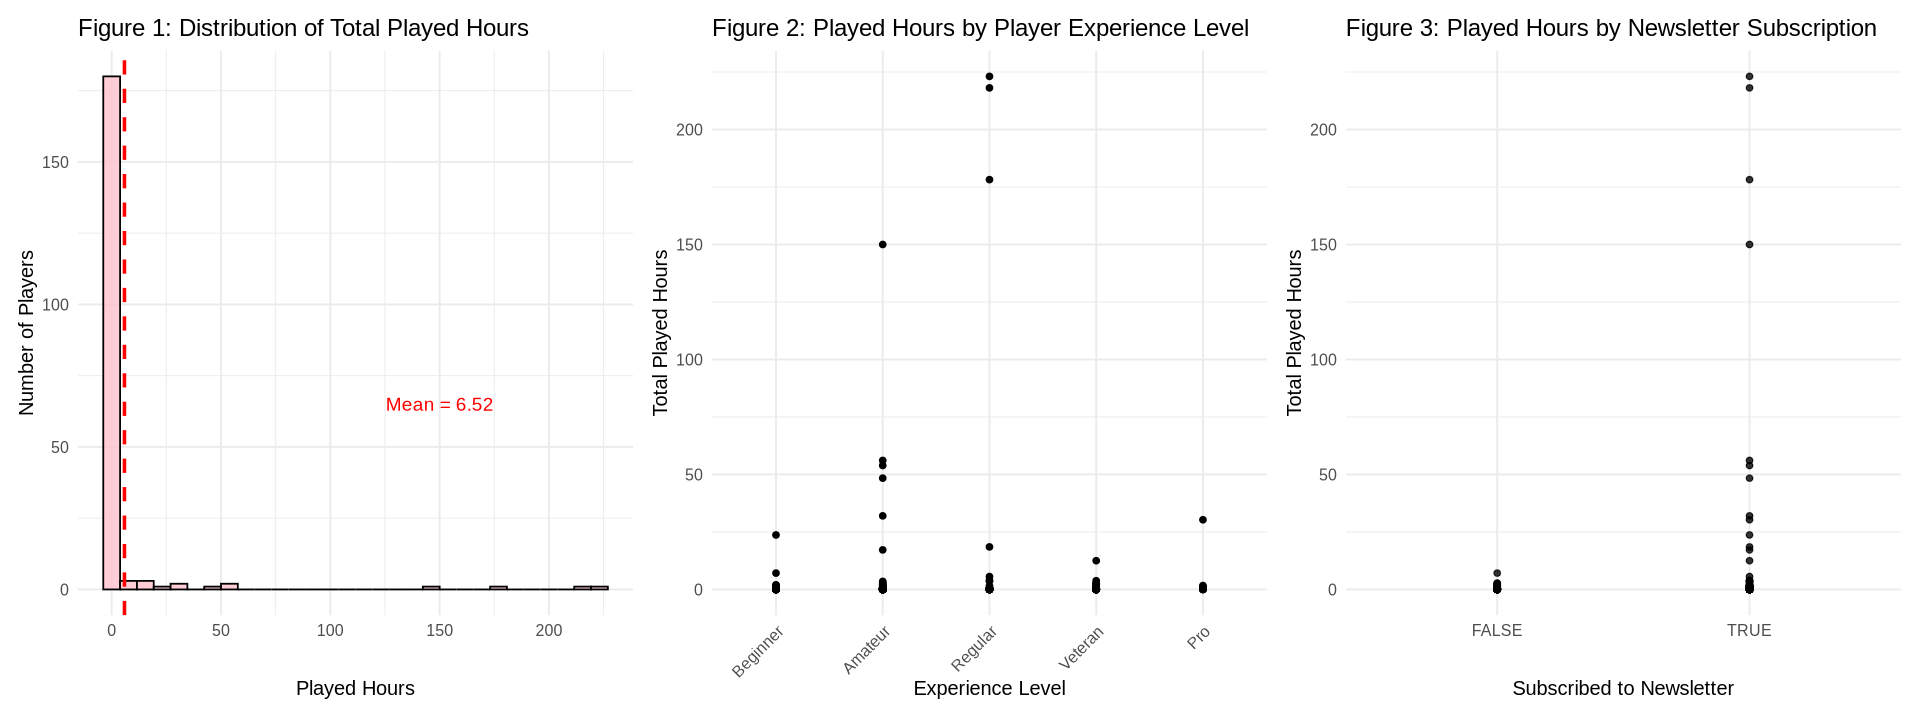

experience,num_players,mean_hours_experience,total_hrs
<fct>,<int>,<dbl>,<dbl>
Beginner,35,1.2485714,43.7
Amateur,63,6.0174603,379.1
Regular,36,18.2083333,655.5
Veteran,48,0.6479167,31.1
Pro,14,2.6000000,36.4


gender,numgender,mean_hrs,tot_hrs
<fct>,<int>,<dbl>,<dbl>
Agender,2,6.25000000,12.5
Female,37,10.63513514,393.5
Male,124,4.12741935,511.8
Non-binary,15,14.88000000,223.2
Other,1,0.20000000,0.2
Prefer not to say,11,0.37272727,4.1
Two-Spirited,6,0.08333333,0.5


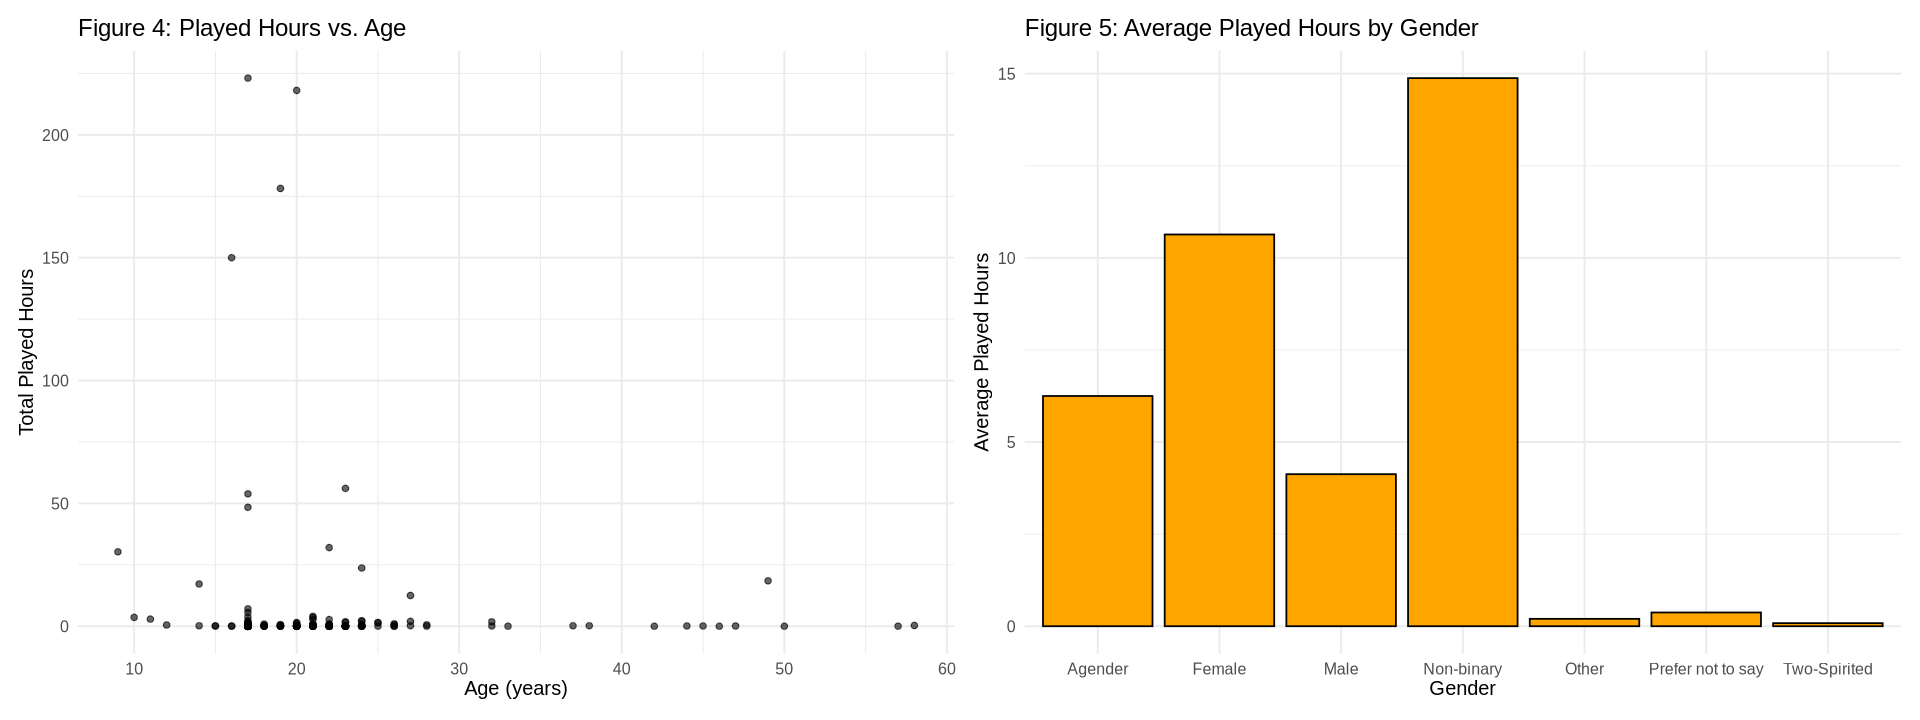

In [28]:
# visualizations of the dataset that is relevant for exploratory data analysis 
# related to the planned analysis
options(repr.plot.width = 16, repr.plot.height = 6)

# Distribution of Total Played Hours
player_distribution <- players_tidy |>
    ggplot(aes(x = played_hours)) +
    geom_histogram(bins = 30, fill = "pink", color = "black", alpha = 0.8) +
    labs(title = "Figure 1: Distribution of Total Played Hours",x = "Played Hours",y = "Number of Players") +
  theme_minimal(base_size = 12) +
  geom_vline(aes(xintercept = mean(played_hours)), 
             color = "red", linetype = "dashed", size = 1) +
  annotate("text", x = 150, y = 65, label = "Mean = 6.52", color = "red", size = 4)


# Played Hours by Player Experience Level
players_experience_hours <- players_tidy |>
  ggplot(aes(x = experience, y = played_hours)) +
  geom_point() +
  labs(title = "Figure 2: Played Hours by Player Experience Level", x = "Experience Level", y = "Total Played Hours") +
  theme_minimal(base_size = 12) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Played Hours by Newsletter Subscription
players_subscribe_hours <- players_tidy |>
  ggplot(aes(x = subscribe, y = played_hours)) +
  geom_point(alpha = 0.8,) +
  labs(title = "Figure 3: Played Hours by Newsletter Subscription", x = "Subscribed to Newsletter", y = "Total Played Hours") +
  theme_minimal(base_size = 12)

# Played Hours vs. Age
players_age_played <- players_tidy |>
  ggplot(aes(x = Age, y = played_hours)) +
  geom_point(alpha = 0.6) +
  labs(title = "Figure 4: Played Hours vs. Age", x = "Age (years)", y = "Total Played Hours") +
  theme_minimal(base_size = 12)

# Average Played Hours by Gender
gender_played <- players |>
  group_by(gender) |>
  summarise(mean_hours = mean(played_hours)) |>
  ggplot(aes(x = gender, y = mean_hours)) +
  geom_bar(stat = "identity", fill = "orange", color = "black") +
  labs(title = "Figure 5: Average Played Hours by Gender", x = "Gender", y = "Average Played Hours") +
  theme_minimal(base_size = 12) 

# proportions across gender
num_gender <- players_tidy |>
    group_by(gender) |>
    summarise(numgender = n(), mean_hrs = (mean(played_hours)), tot_hrs= (sum(played_hours)))

# proportions across experience
skillset_counts <- players_tidy |>
  group_by(experience) |>
  summarise(n_players = n()) |>
  mutate(percentage = round(100 * n_players / sum(n_players), 1))|>
  ungroup()

proportion <- players_tidy |> 
    group_by(experience) |>
    summarise(num_players = n(), mean_hours_experience = mean(played_hours), total_hrs = sum(played_hours))

# print out vizualization side by side
(player_distribution + players_experience_hours + players_subscribe_hours)
(players_age_played + gender_played)
proportion
num_gender

**insights**

figure 1 distribution of played hours: most players (>175 of 196 players) are in the 0 hour play time with very few high level of hours shows importance of recruiting targeted individuals since data contribution comes from minority.

according to figure 2 played hours by experience level and the proportions on the different experience level (the first tibble), players with most time spent on the game are amateur or regular players. Regular players have the most hours played as well as the highest average playtime by player. Regular players should be targeted since they are most likely to play for longer periods of time. 

figure 3 played hours by newsletter subscription : subscribtion to the newsletter shows pretty stronger playtimes and none of the players unsubscribed to the newsletter show good playtime. We should rule out people who arent subscribed to the newsletting with recruting. 

figure 4 played hours vs. age: ages 15 - 20 contain the players with longest playtime but also have most player. ages 15 - 20 could be targetted for willing players but would be heavily skewed with most players not engaging
* reason why excluded as a predictor

figure 5 Average played hours by gender and proportions of players gender (the second tibble): Imbalance some groups too small or too big, Many gender diverse terms bring ambiguity. Maybe group some together Insight:  Non-binary players will play the longest on average despite being a small group of people

In [29]:
## Encode gender variable to Male, Female, and Other
players_tidy <- players_tidy |> mutate(
    gender = case_when(
      gender %in% c("Male") ~ "Male",
      gender %in% c("Female") ~ "Female",
      TRUE ~ "Other"),
    gender = as.factor(gender))
players_tidy

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,47


In [30]:
players_number <- players_tidy |> 
mutate(gender = case_when(
      gender %in% c("Male") ~ 1,
      gender %in% c("Female") ~ 2,
      TRUE ~ 3))|>

mutate(experience = case_when(
      experience %in% c("Beginner") ~ 1,
      experience %in% c("Amateur") ~ 2,
      experience %in% c("Regular") ~ 3,
      experience %in% c("Pro") ~ 4,
      experience %in% c("Veteran") ~ 5))|>

mutate(subscribe = case_when(
      subscribe %in% c("TRUE") ~ 1,
      subscribe %in% c("FALSE") ~ 0))


players_number <- players_number|>
    mutate(
        Age = as.numeric(Age),
        subscribe = as.numeric(subscribe),
        experience = as.numeric(experience),
        gender = as.numeric(gender))
players_number

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
4,1,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,1,9
5,1,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,1,17
5,0,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,1,17
2,1,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,2,21
3,1,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,1,21
2,1,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,2,17
3,1,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,2,19
2,0,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,1,21
2,1,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,1,47


In [31]:
## Select for only predictors and target variables
players_selected <- select(players_number, Age, experience, subscribe, gender, played_hours)|>
    drop_na()
players_selected

Age,experience,subscribe,gender,played_hours
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9,4,1,1,30.3
17,5,1,1,3.8
17,5,0,1,0.0
21,2,1,2,0.7
21,3,1,1,0.1
17,2,1,2,0.0
19,3,1,2,0.0
21,2,0,1,0.0
47,2,1,1,0.1


In [32]:
## Split the data 80/20 
players_split <- initial_split(players_selected, prop = 0.80, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)

In [42]:

## Find Best k value for KNN Regression

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

players_recipe <- recipe(played_hours ~ ., data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 


## 5 Fold Validation
players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)
gridvals <- tibble(neighbors = seq(from = 1, to = 16, by = 1))

players_workflow <-  workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_spec)

players_results <- players_workflow |>
  tune_grid(resamples = players_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")

players_min <- players_results |>
  filter(mean == min(mean))

players_min

k_min <- players_min$neighbors

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
16,rmse,standard,25.76359,5,7.814585,Preprocessor1_Model16


In [43]:
## Predict KNN with K min RSME
players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
         set_engine("kknn") |>
         set_mode("regression")

players_best_fit <- workflow() |>
         add_recipe(players_recipe) |>
         add_model(players_best_spec) |>
         fit(data = players_training)

players_summary <- players_best_fit |>
          predict(players_testing) |>
          bind_cols(players_testing) #|>

players_metrics <- players_summary |>
        metrics(truth = played_hours, estimate = .pred)

head(players_summary)

players_metrics

.pred,Age,experience,subscribe,gender,played_hours
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.38750,17,5,0,1,0.0
11.48125,22,5,1,2,0.0
3.33125,25,1,1,2,1.5
5.73125,22,2,1,1,0.2
14.61250,17,3,1,1,0.0
3.48125,17,2,1,1,0.0


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,23.40734694
rsq,standard,0.02755972
mae,standard,10.19250000


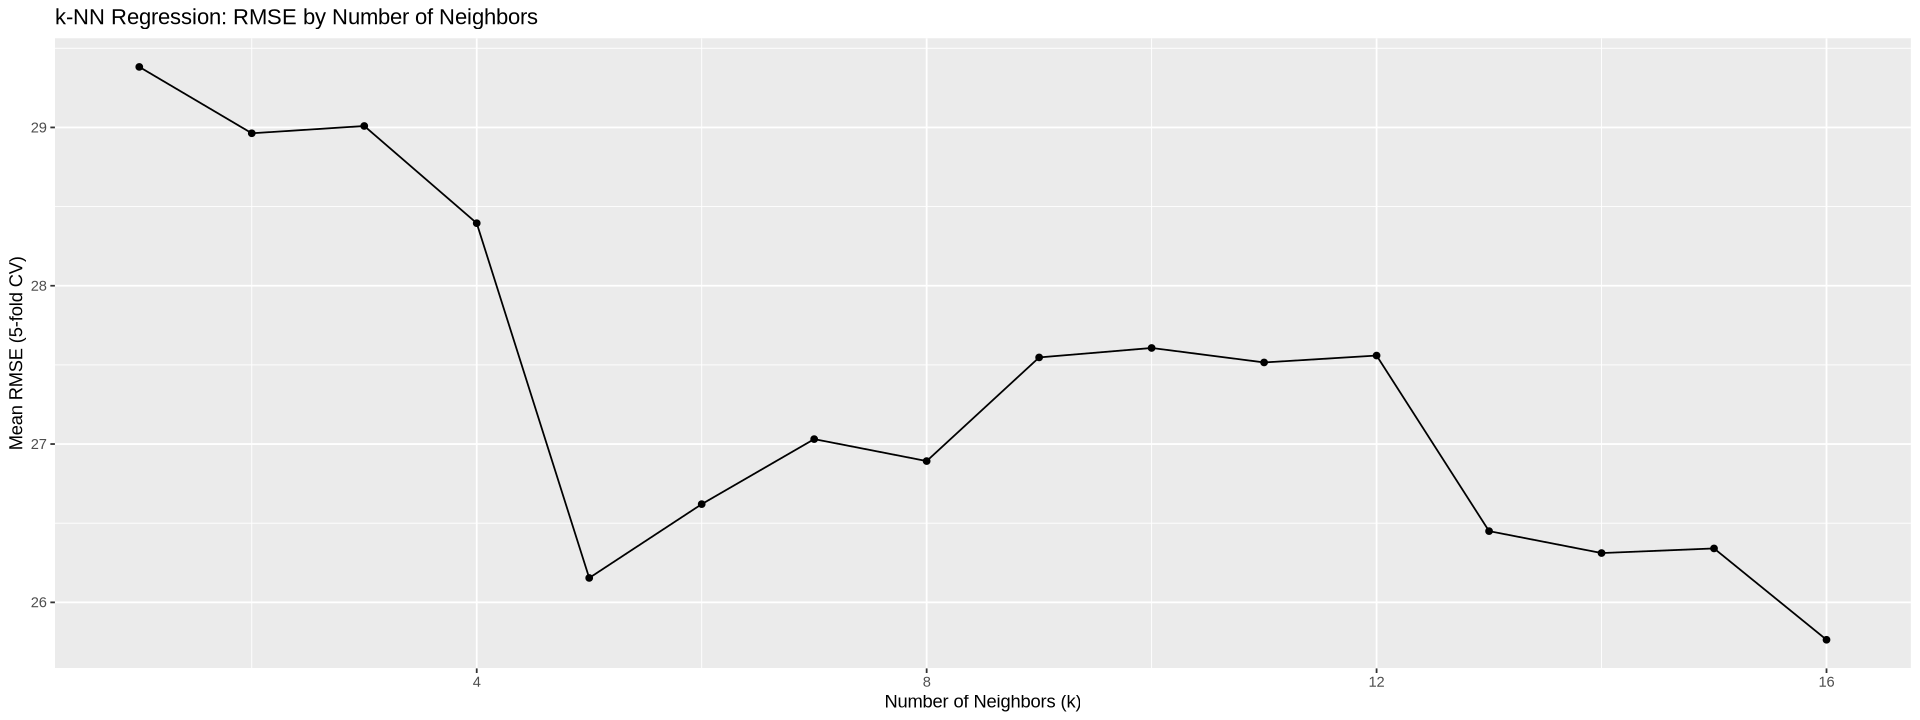

In [44]:
k_plot <- players_results |>
  filter(.metric == "rmse") |>
  ggplot(aes(x = neighbors, y = mean)) +
  geom_line() +
  geom_point() +
  labs(
    title = "k-NN Regression: RMSE by Number of Neighbors",
    x = "Number of Neighbors (k)",
    y = "Mean RMSE (5-fold CV)")
k_plot

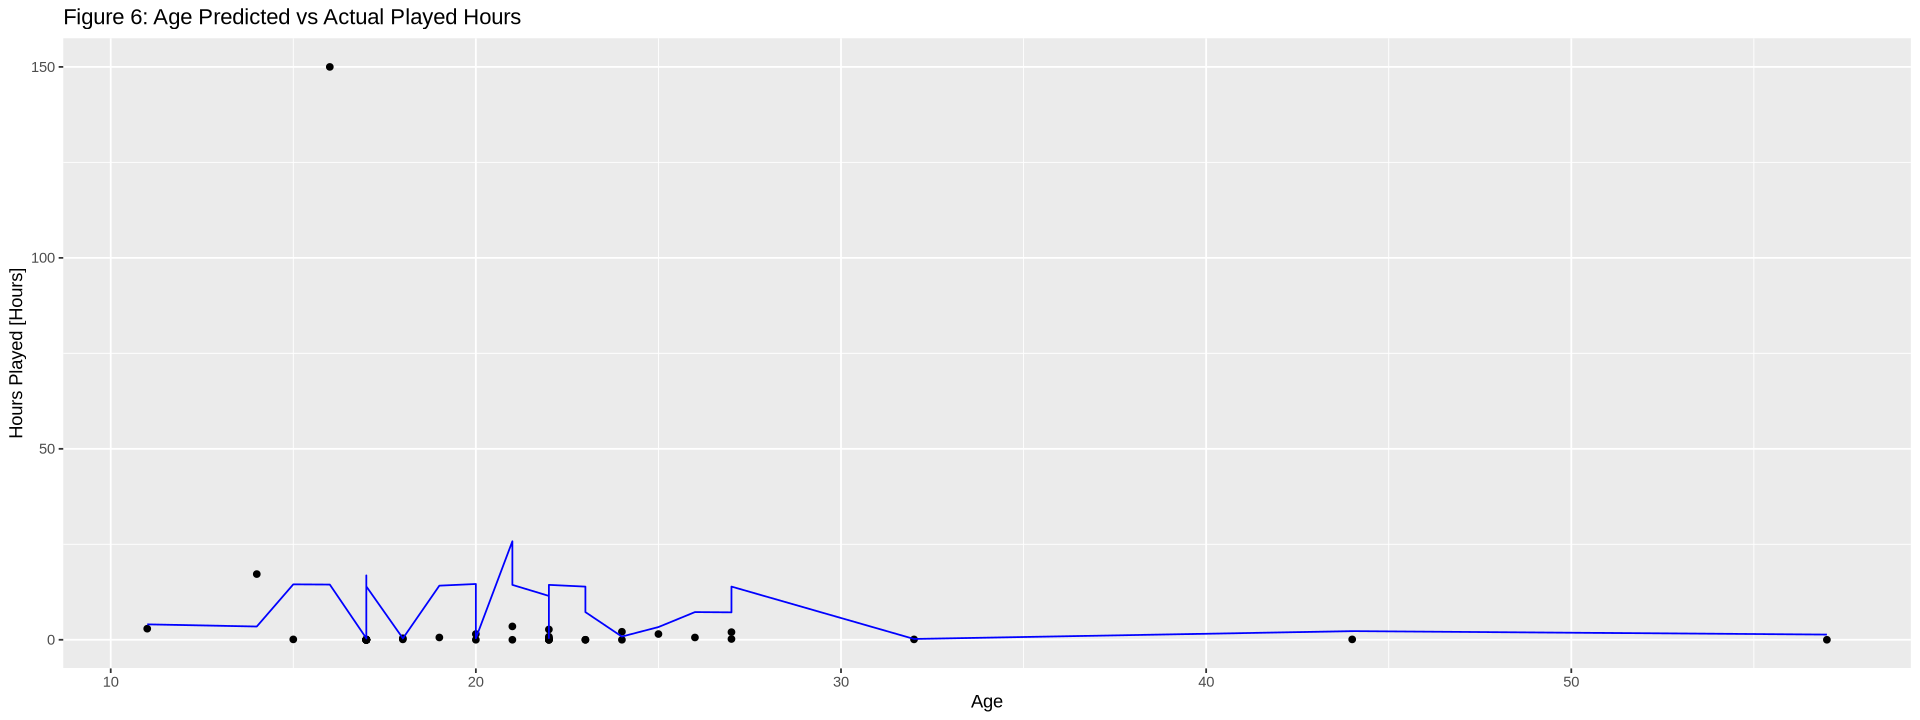

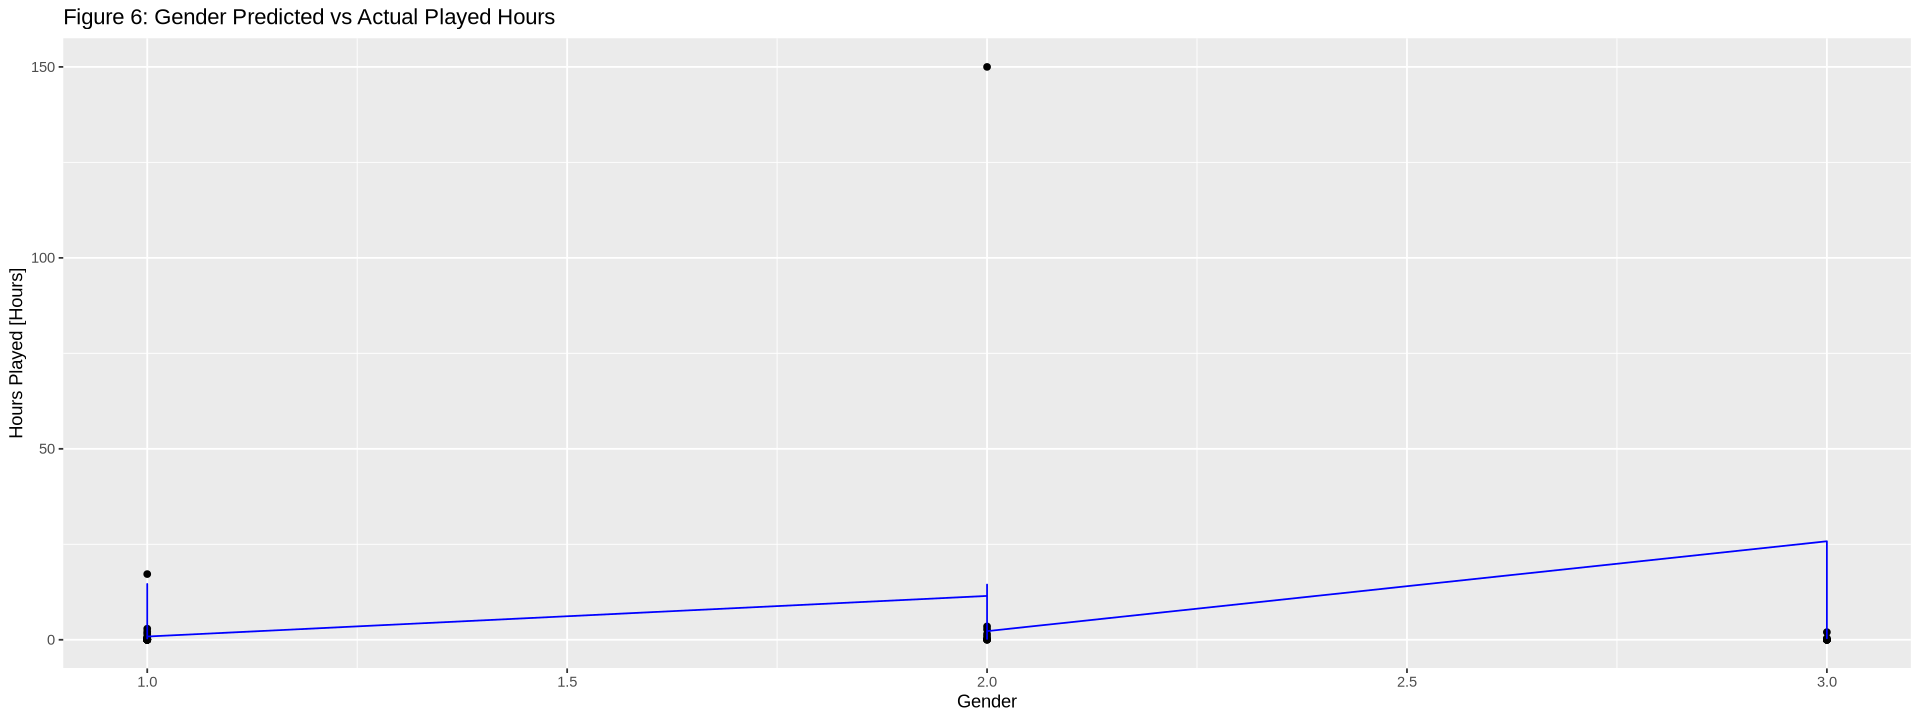

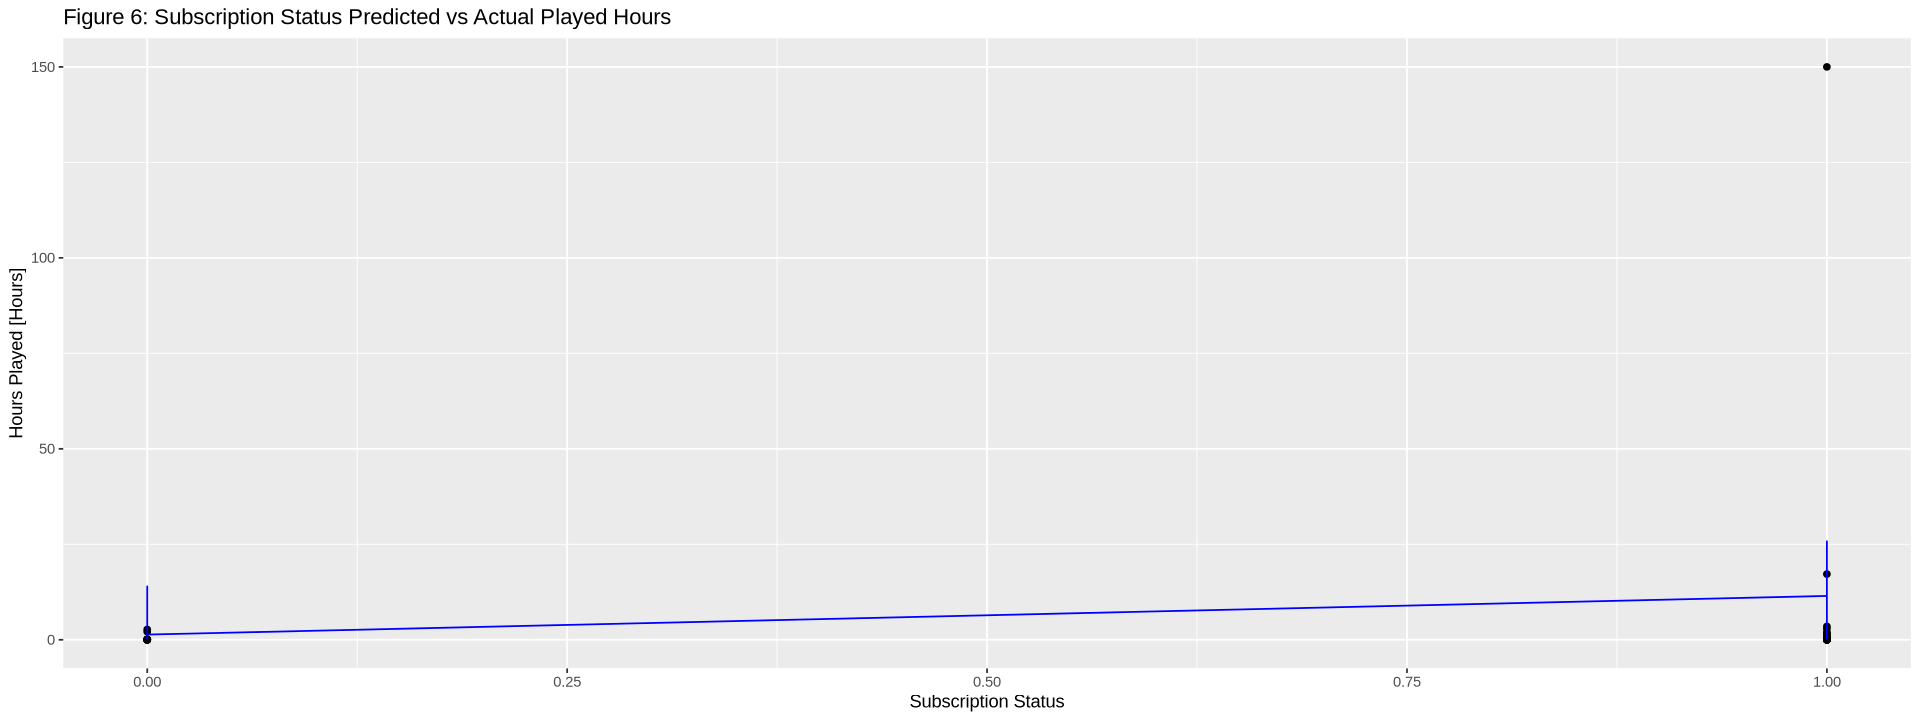

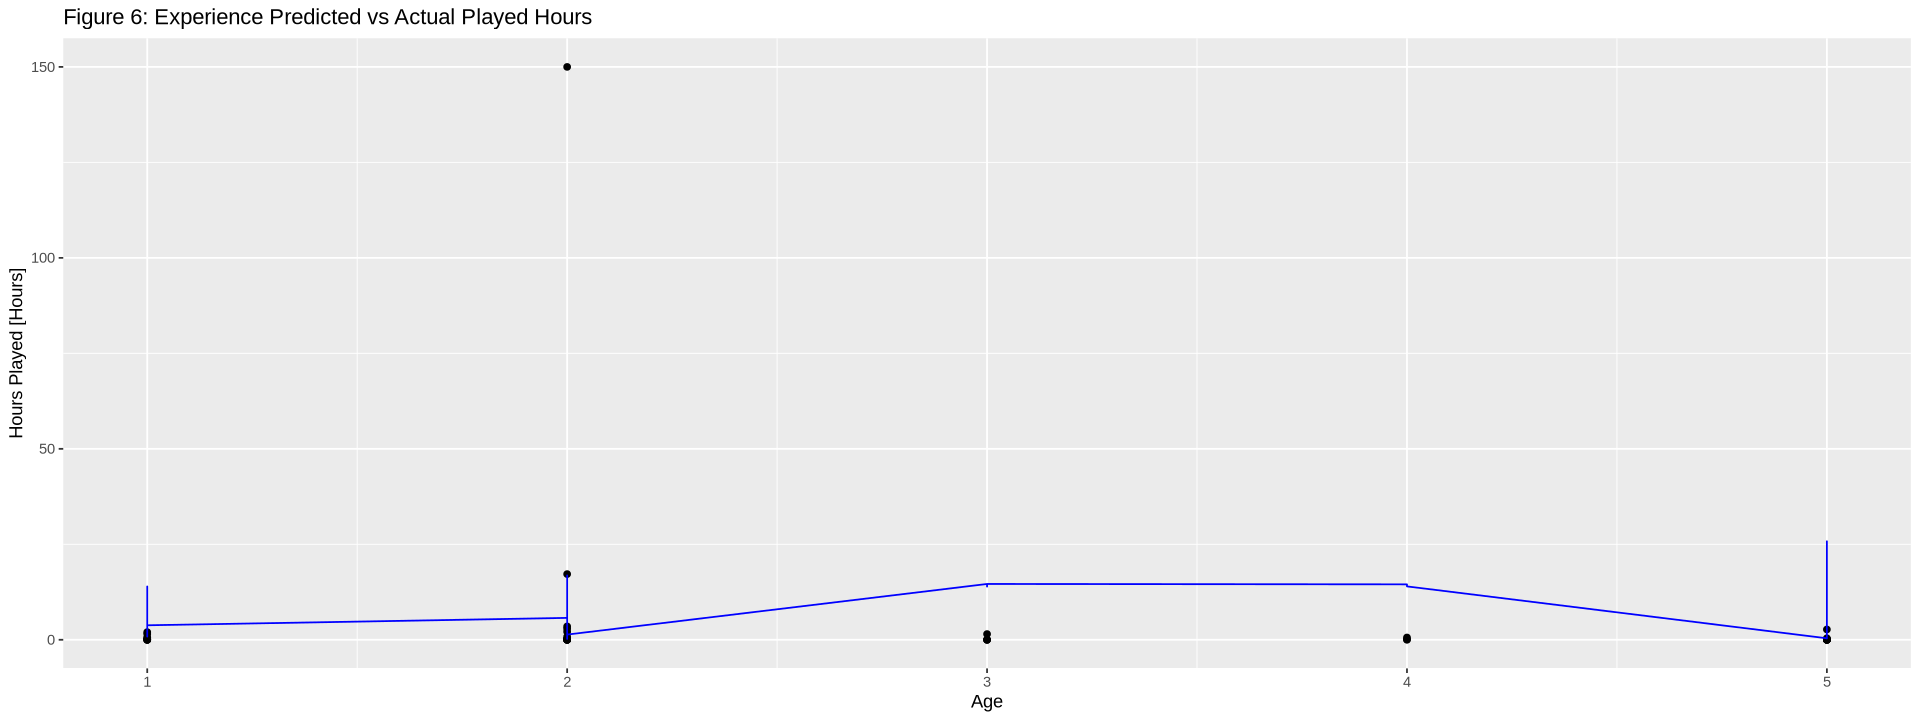

In [45]:
## Plot the KNN Results

players_pred_plot_age <- players_summary |>
      ggplot(aes(x = Age, y = played_hours)) +
      geom_point() +
      geom_line(aes(x = Age, y = .pred), color = "blue") +
      labs(
        title = "Figure 6: Age Predicted vs Actual Played Hours",
        x = "Age",
        y = "Hours Played [Hours]")

players_pred_plot_gender <- players_summary |>
      ggplot(aes(x = gender, y = played_hours)) +
      geom_point() +
      geom_line(aes(x = gender, y = .pred), color = "blue") +
      labs(
        title = "Figure 6: Gender Predicted vs Actual Played Hours",
        x = "Gender",
        y = "Hours Played [Hours]")

players_pred_plot_subscribe <- players_summary |>
      ggplot(aes(x = subscribe, y = played_hours)) +
      geom_point() +
      geom_line(aes(x = subscribe, y = .pred), color = "blue") +
      labs(
        title = "Figure 6: Subscription Status Predicted vs Actual Played Hours",
        x = "Subscription Status",
        y = "Hours Played [Hours]")

players_pred_plot_experience <- players_summary |>
      ggplot(aes(x = experience, y = played_hours)) +
      geom_point() +
      geom_line(aes(x = experience, y = .pred), color = "blue") +
      labs(
        title = "Figure 6: Experience Predicted vs Actual Played Hours",
        x = "Age",
        y = "Hours Played [Hours]")
       
players_pred_plot_age
players_pred_plot_gender
players_pred_plot_subscribe
players_pred_plot_experience


The Predicted vs Actual Played Hours plot reveals that the k-NN regression model performed poorly in estimating players’ actual playtime. Ideally, predictions should align closely with the 45-degree dashed line, indicating accurate estimates. Instead, the majority of predicted values cluster near zero, even when the actual played hours span a much wider range. This pattern shows that the model systematically underestimates higher playtime values and fails to capture the underlying relationships in the data. The few points with larger predicted values do not correspond meaningfully to their actual values, suggesting inconsistent behavior from the model. This visual assessment aligns with the quantitative metrics (R² ≈ 0.002, RMSE ≈ 5), which indicate that the model explains virtually none of the variance in played hours and makes large prediction errors. Overall, the plot confirms that the k-NN regression model is not effective for this dataset, likely due to weak predictor–target relationships and the presence of categorical predictors that k-NN handles poorly.

# Discussion 
- summarize what you found discuss whether this is what you expected to find discuss what impact could such findings have
- discuss what future questions could this lead to 




# References: 
You may include references if necessary, as long as they all have a consistent citation style.